In [37]:
import pandas as pd
import jinja2
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [38]:
# read the csv file
match_data_unfiltered = pd.read_csv("preprocessed_dataframe_with_elo_1.csv")

In [39]:
# make FTR column to continous variable
def convert_ftr(result: str):
    if result == "D":
        return 0
    elif result == "H":
        return 1
    elif result == "A":
        return -1
    else: 
        return None
match_data_unfiltered['FTR'] = match_data_unfiltered['FTR'].apply(convert_ftr)

In [40]:
match_data_unfiltered = match_data_unfiltered.drop(["Unnamed: 0"], axis=1, errors="ignore")
# print(match_data_unfiltered.columns)
match_data_unfiltered.tail(n=5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
4891,14.05.2022,Mainz,Ein Frankfurt,2,2,0,1,2,A,13,...,2,-2,1,-1,2,-1,0,0,849,844
4892,14.05.2022,M'gladbach,Hoffenheim,5,1,1,3,1,H,19,...,4,0,1,-5,1,-1,2,-4,877,855
4893,14.05.2022,Stuttgart,FC Koln,2,1,1,1,0,H,24,...,2,-1,0,-1,1,-1,0,0,734,762
4894,14.05.2022,Union Berlin,Bochum,3,2,1,2,0,H,17,...,3,-1,2,-2,2,0,2,-1,746,389
4895,14.05.2022,Wolfsburg,Bayern Munich,2,2,0,1,2,A,10,...,1,-1,2,-2,1,0,2,-2,825,1118


In [41]:
# print correlation matrix
correlation_matrix_match_data_unfiltered = match_data_unfiltered.corr()
correlation_matrix_match_data_unfiltered.style.background_gradient()

,FTHG,FTAG,FTR,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HomeElo,AwayElo,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
FTHG,1.000000,-0.115890,0.632818,0.691083,-0.066105,0.282759,-0.121474,0.529431,-0.122165,-0.110952,-0.079891,0.024723,-0.068897,-0.128651,0.020357,-0.084379,0.065876,0.192706,-0.072156,0.928358,0.104481,-0.126147,-0.899074,0.141632,0.051932,-0.066842,-0.048490,0.165839,-0.045698
FTAG,-0.115890,1.000000,-0.652825,-0.077238,0.681759,-0.110333,0.297404,-0.118181,0.534106,-0.010506,-0.051651,-0.042649,0.063109,0.091277,-0.060410,0.134629,-0.058063,-0.050974,0.172909,-0.108278,-0.900764,0.872638,0.125409,-0.040003,-0.039773,0.115151,0.035588,-0.028324,0.149921
FTR,0.632818,-0.652825,1.000000,0.425434,-0.439499,0.189774,-0.201513,0.354642,-0.369956,-0.043109,0.004917,-0.007333,-0.040962,-0.114128,0.059165,-0.138916,0.090794,0.136225,-0.151012,0.572120,0.583456,-0.581807,-0.567144,0.108748,0.061221,-0.107760,-0.041040,0.100927,-0.115716
HTHG,0.691083,-0.077238,0.425434,1.000000,-0.078063,0.126746,-0.059225,0.339639,-0.082490,-0.049028,-0.053229,-0.037902,-0.006581,-0.111528,0.013452,-0.029325,0.020904,0.128916,-0.044013,0.645407,0.078543,-0.081372,-0.612730,0.104650,0.039166,-0.038659,-0.015683,0.110668,-0.026036
HTAG,-0.066105,0.681759,-0.439499,-0.078063,1.000000,-0.017061,0.147804,-0.047770,0.331774,0.001003,-0.007671,0.032551,-0.000917,0.075908,-0.053471,0.064540,-0.000982,-0.027334,0.134705,-0.063344,-0.606669,0.598045,0.078990,-0.015087,-0.018007,0.086451,0.021355,-0.012253,0.119304
HS,0.282759,-0.110333,0.189774,0.126746,-0.017061,1.000000,-0.316971,0.664345,-0.199804,-0.120852,0.039524,0.508935,-0.254611,-0.121168,0.055733,-0.103701,0.095520,0.063736,-0.189992,0.272917,0.093084,-0.140922,-0.256431,0.126892,0.059543,-0.108198,-0.041782,0.060764,-0.186795
AS,-0.121474,0.297404,-0.201513,-0.059225,0.147804,-0.316971,1.000000,-0.199331,0.676266,0.064472,-0.076242,-0.244556,0.486411,0.108685,-0.061900,0.097864,-0.082758,-0.122667,0.106571,-0.125573,-0.256728,0.279938,0.128215,-0.092458,-0.077107,0.100707,0.055362,-0.118995,0.103004
HST,0.529431,-0.118181,0.354642,0.339639,-0.047770,0.664345,-0.199331,1.000000,-0.087377,-0.052120,0.032089,0.311088,-0.159436,-0.116918,0.036144,-0.086779,0.089747,0.016793,-0.235931,0.498386,0.100998,-0.139105,-0.469711,0.136727,0.074331,-0.098489,-0.043370,0.005260,-0.223890
AST,-0.122165,0.534106,-0.369956,-0.082490,0.331774,-0.199804,0.676266,-0.087377,1.000000,0.064358,-0.023169,-0.145561,0.322492,0.098727,-0.067452,0.092219,-0.059565,-0.153934,0.055267,-0.117509,-0.480846,0.467809,0.129396,-0.065488,-0.059450,0.087395,0.050601,-0.142572,0.044197
HF,-0.110952,-0.010506,-0.043109,-0.049028,0.001003,-0.120852,0.064472,-0.052120,0.064358,1.000000,0.350923,-0.083828,0.012621,0.322449,0.097079,0.076233,0.059689,-0.444572,-0.368586,-0.138452,-0.000261,-0.023892,0.092007,-0.142493,-0.055674,-0.027370,0.000638,-0.442940,-0.367831


In [42]:
# filter for specific columns
# match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeElo", "AwayElo", "HomeAttack", "HomeDefend", "AwayAttack", "AwayDefend"]]
# "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    # "AwayAttackOld", "AwayDefendOld"
# print correlation matrix
match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld", "AwayAttackOld", "AwayDefendOld"]]

correlation_matrix_match_data_reduced = match_data_reduced.corr()
correlation_matrix_match_data_reduced.style.background_gradient()

,FTR,FTHG,FTAG,HomeEloOld,AwayEloOld,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld
FTR,1.000000,0.632818,-0.652825,0.100927,-0.115716,0.108748,0.061221,-0.107760,-0.041040
FTHG,0.632818,1.000000,-0.115890,0.165839,-0.045698,0.141632,0.051932,-0.066842,-0.048490
FTAG,-0.652825,-0.115890,1.000000,-0.028324,0.149921,-0.040003,-0.039773,0.115151,0.035588
HomeEloOld,0.100927,0.165839,-0.028324,1.000000,0.668087,0.216021,0.049508,0.028283,-0.019703
AwayEloOld,-0.115716,-0.045698,0.149921,0.668087,1.000000,0.052028,-0.025494,0.217028,0.066102
HomeAttackOld,0.108748,0.141632,-0.040003,0.216021,0.052028,1.000000,0.138647,0.011529,0.012026
HomeDefendOld,0.061221,0.051932,-0.039773,0.049508,-0.025494,0.138647,1.000000,0.004358,0.016697
AwayAttackOld,-0.107760,-0.066842,0.115151,0.028283,0.217028,0.011529,0.004358,1.000000,0.104514
AwayDefendOld,-0.041040,-0.048490,0.035588,-0.019703,0.066102,0.012026,0.016697,0.104514,1.000000


In [43]:
X = match_data_unfiltered.loc[:, ["HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    "AwayAttackOld", "AwayDefendOld"
]]

y = match_data_unfiltered.loc[:, ["FTR"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [44]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [45]:
clf.predict(X_test)

array([ 1,  1,  1, ...,  0, -1,  1], dtype=int64)

In [46]:
result = clf.score(X_test, y_test)

In [47]:
result

0.41027227722772275

Confusion matrix, without normalization
[[183 135 181]
 [120 125 161]
 [178 178 355]]
Normalized confusion matrix
[[0.36673347 0.27054108 0.36272545]
 [0.2955665  0.30788177 0.39655172]
 [0.25035162 0.25035162 0.49929677]]


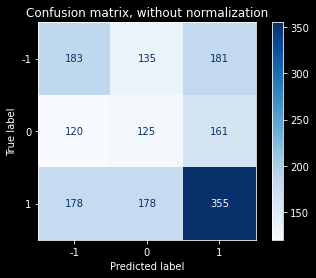

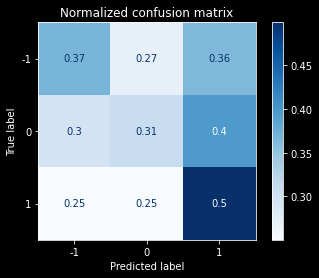

In [48]:
class_names = {
    'Away'
    ,'Draw',
    'Home'
}
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()